In [6]:
## Uncomment the lines below to install the necessary libraries in binder

#import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install mip
#!{sys.executable} -m pip install xlrd


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm, rcParams

rcParams["font.size"] = "12"


from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

import os
import re
import string
from mip import *
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### A. Problem parameters
First we import the data from the Excel file into a Pandas dataframe *data*. For convenience, we rename the columns as in the Excel file, using upper-case letters.

In [7]:

data = pd.read_excel('ORscheduling_Complete (1).xlsx',header=None)

new_names = string.ascii_uppercase[:len(data.columns)] ## as many letters as needed
rename_dict = dict(zip(data.columns,new_names))             

data.rename(columns=rename_dict,inplace=True)


Part of the Pandas dataframe *data* is shown below.Please uncomment the last line to see the entire dataframe.

In [11]:
data.head(56)
data.tail(0)
#data

,A,B,C,D,E,F,G,H,I,J,...,N,O,P,Q,R,S,T,U,V,W
0,OR Scheduling,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Ors,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,# of Surgical Teams per Department per Day,NaN,NaN,NaN,NaN,NaN,NaN,Min # of ORs per day,NaN,NaN,...,Max # of ORs per day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,M,T,W,R,F,NaN,M,T,W,...,M,T,W,R,F,NaN,NaN,NaN,NaN,NaN
6,Pediatric surgery,1,2,1,2,1,NaN,0,0,0,...,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN
7,General Surgery,4,4,8,4,4,NaN,2,2,4,...,8,8,8,8,8,NaN,NaN,NaN,NaN,NaN
8,Ophthalmologist,2,2,2,4,2,NaN,0,0,0,...,4,4,4,4,4,NaN,NaN,NaN,NaN,NaN
9,Neurosurgery,2,2,2,2,2,NaN,1,1,1,...,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN


,A,B,C,D,E,F,G,H,I,J,...,N,O,P,Q,R,S,T,U,V,W


Next we import the various regions containing the parameters of the problem into Numpy arrays. Note that, contrary to the usual convention in Python, the range or rows defined in each call to *data.loc()*, say *data.loc(n<sub>1</sub>:n<sub>2</sub>,'A')* <u>includes</u> the last row defined in the range, i.e. *n<sub>2</sub>* in this case. 

* The **departments**:



In [12]:
print('Departments:\n')
departments = data.loc[6:16,'A'].values
print(departments)


Departments:

['Pediatric surgery' 'General Surgery' 'Ophthalmologist' 'Neurosurgery'
 'Τhoracic surgery and Cardiac surgery' 'Orthopedics' 'University Surgery'
 'Otolaryngology' 'Plastic Surgery' 'Urology' 'Septic Surgery']


* The **available surgical teams**, per department, per day</b>:



In [13]:

## Surgical Teams per Department per Day
print('\nTeams availability per department (rows) per day (columns):\n')
available_teams = data.loc[6:16,'B':'F'].values.astype(int)
print(available_teams)



Teams availability per department (rows) per day (columns):

[[1 2 1 2 1]
 [4 4 8 4 4]
 [2 2 2 4 2]
 [2 2 2 2 2]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [2 2 2 2 4]
 [2 1 2 1 2]
 [4 2 4 2 4]
 [2 2 2 2 2]
 [1 1 1 1 2]]


* The **minimum and maximum numbers of operational rooms**, per department, per day</b>:



In [14]:
## Min # of ORs per day
print('\nMinimum number of ORs per department (rows) per day (columns):\n')
min_ors = data.loc[6:16,'H':'L'].values.astype(int)
print(min_ors)

## Max # of ORs per day
print('\nMaximum number of ORs per department (rows) per day (columns):\n')
max_ors = data.loc[6:16,'N':'R'].values.astype(int)
print(max_ors)




Minimum number of ORs per department (rows) per day (columns):

[[0 0 0 0 0]
 [2 2 4 2 2]
 [0 0 0 2 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [2 2 1 2 1]
 [1 1 0 1 2]
 [1 0 1 0 0]
 [2 1 2 1 2]
 [0 0 0 0 1]
 [0 0 0 0 0]]

Maximum number of ORs per department (rows) per day (columns):

[[2 2 2 2 2]
 [8 8 8 8 8]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [4 4 4 4 4]
 [2 2 2 2 2]
 [1 1 1 1 2]]


* The **minimum and maximum weekly department requirements for operational rooms**, per department:



In [15]:

## Weekly Department Requirements
print('\nWeekly department requirements (1st column: min/ 2nd column: max):\n')
weekly_reqs = data.loc[21:31,'B':'C'].values.astype(int)
print(weekly_reqs)



Weekly department requirements (1st column: min/ 2nd column: max):

[[ 0 10]
 [12 40]
 [ 2 20]
 [ 5 10]
 [10 20]
 [ 8 10]
 [ 5 20]
 [ 2 10]
 [ 8 20]
 [ 1 10]
 [ 0  6]]


* And finally, the **weekly targets per department**, in hours per week:



In [16]:

## Weekly Department Targets
print('\nWeekly targets per department (hours):\n')
weekly_targets = data.loc[21:31,'H'].values.astype(float)
print(weekly_targets)



Weekly targets per department (hours):

[ 14. 168.  84.  70. 140.  70.  84.  56. 112.  70.   7.]


### B. Problem formulation

This is an integer programming (IP) problem. The mathematical formulation is as follows. The decision variables are the operational rooms assigned to each department *i*, each day *j*. Let us denote these variables by $x_{ij}, i=1,...,11, j=1,...,5$. 


The **objective function** to **maximize** is the sum of the percentages of the weekly targets achieved. For each department *i*, the total hours worked per week are $7\sum_{j=1}^5 x_{ij}$ and the fraction of the corresponding weekly target for department *i*, say $t_i$, is $\frac{7}{t_i}\sum_{j=1}^5 x_{ij}$ 

Therefore, the objective function is: 


$\begin{aligned} max z=\sum_{i=1}^11\frac{7}{t_i}\sum_{j=1}^5 x_{ij} \end{aligned}$


The **constraints** are as follows:

The total number of operating rooms each day has to be less than or equal to 14: 
 
$\begin{aligned} \sum_{i=1}^11 x_{ij}\leq 14 \quad j=1,...,5 \quad(C_1)\end{aligned}$
 
The operating rooms are less than or equal to the available surgical teams, for each department and day: 
 
$\begin{aligned} x_{ij} \leq a_{ij} \quad i=1,...,11 \quad j=1,...,5 \quad(C_2) \end{aligned}$ 

where $a_{ij}$ are the available surgical teams in department *i* and day *j*. 

The operating rooms are also a) greater than or equal to the minimum specified ones, for each department and day, b) less  than or equal to the maximum specified ones, for each department and day:
 
$\begin{aligned} x_{ij} \geq m_{ij}^- \quad i=1,...,11 \quad j=1,...,5 \quad(C_3) \end{aligned}$ 

$\begin{aligned} x_{ij} \leq m_{ij}^+ \quad i=1,...,11 \quad j=1,...,5 \quad(C_4) \end{aligned}$ 

where $m_{ij}^-$ and $m_{ij}^+$ are the minimum and maximum values, per department *i* and day *j*. 



In each department, the weekly numbers of operating rooms are between the minimum and maximum requirements: 
 
$\begin{aligned} \sum_{j=1}^5 x_{ij}\geq w_{i}^- \quad i=1,...,11 \quad(C_5)\end{aligned}$ 

$\begin{aligned} \sum_{j=1}^5 x_{ij}\leq w_{i}^+ \quad i=1,...,11 \quad(C_6)\end{aligned}$ 

where $w_{i}^-$ and $w_{i}^+$ are the minimum and maximum, respectively, weekly requirements for operating rooms in department *i*. 

In each department, the weekly numbers of operating rooms are less than or equal to the weekly targets: 
 
$\begin{aligned} \sum_{j=1}^5 x_{ij}\leq t_{i} \quad i=1,...,11 \quad(C_7)\end{aligned}$ 

where $t_{i}$ are the weekly targets in department *i*. 

The **decision variables** are:

$x_{ij} $ nonnegative integers: $x_{ij}\in Z^*=\{0\}\cup Z^+ \quad i=1,...,11 \quad  j=1,...,5$. 
 

### C. Modeling the problem using the mip package commands

We use the Python [mip package](https://docs.python-mip.com/en/latest/intro.html). First, we initialize a model *m*, we define the direction of the optimization (*MAXIMIZE*) and select the solver (the default, *CBC*). *CBC* stands for Coin-or branch and cut, and is an open-source Mixed Integer Programming (MIP) library using the [branch-and-cut approach](https://en.wikipedia.org/wiki/Branch_and_cut), i.e. combining the classic branch-and-bound method with cutting planes for the tightening of the bounds. 

Next, we define the 55 decision variables and give them names $xi\_j$ using the function *add_var()*. In the same command, we select their type as *INTEGER* and also set their lower and upper bounds - from constraints $(C3)$ and $(C4)$ - using the arrays *min_ors* and *max_ors*. We incorporate also constraints $(C2)$ (operating rooms are $\leq $ available surgical teams),
in the upper bounds, using array *available_teams* and use the *minimum* (i.e. tighter) of the two upper bounds.

Note that we use subscripts for the departments (*i*) and days (*j*) from 1 to 5. Therefore, when using the other data of the problem, we deduct one <br> from *i* and/or *j*.

Finally, we define the objective function (property *objective*), according to the formulation in section **B**, using data from array *weekly_targets*. Note that we use the function *var_by_name()* to refer to a variable by its name rather than by an index. Also, we use the function *xsum()* to add several variables together.  


In [25]:

m = Model(name='Operation Rooms',sense=MAXIMIZE, solver_name=CBC) 


## Daily # ORs assigned is integer
x = [m.add_var(name='x'+str(i)+'_'+str(j),var_type=INTEGER, \
               lb = min_ors[i-1,j-1], ub= min(max_ors[i-1,j-1],available_teams[i-1,j-1])) \
                  for i in range(1,11) for j in range(1,6)]

m.objective = xsum(xsum(8/weekly_targets[i-1]*m.var_by_name('x'+str(i)+'_'+str(j)) \
                  for j in range(1,6)) for i in range(1,11)) 


Next we add the first constraints $(C1)$ (total number of operating rooms each day $\leq 14$). We use the += shorthand notation for the function *add_constr()* and again use function *xsum()* to add several variables together. 

As with the objective function, we refer to variables using their names, with the function *var_by_name()*. 

In [26]:

## Total # ORs each day
## the total number of operating rooms each day has to be less than or equal to 14.
for j in range(1,6):
    m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for i in range(1,11)) <= 14 


The next constraints $(C5)$ and $(C6)$ are very similar and express the constraints due to the minimum / maximum weekly requirements for operating rooms. We use array *weekly_reqs* where the first column (0) has the minimum values and the second column (1) has the maximum ones.

Finally, we add constraints $(C7)$ which put upper bounds (weekly targets) on the weekly numbers of operating rooms, for each department. The values for the right side are taken from array *weekly_targets*.


In [28]:

## UB: Weekly Dept OR requirement
## LB: Weekly Dept OR requirement
for i in range(1,11):
    m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) >= weekly_reqs[i-1,0] #,'week_'+str(j)+' min'
for i in range(1,11):
    m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) <= weekly_reqs[i-1,1] #,'week_'+str(j)+' max'

    
## ----------------------------------------------------------------
## Departmental Targets
for i in range(1,11):
    m += 7*xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) <= weekly_targets[i-1] #,'weekly_target_'+str(i)




We check the model by writing it in *lp format* in a file *model.lp*. We read back this file and examine it (see next output). We could have written the model also in the more portable *mps format* (by only changing the file extension to *.mps*) but this latter format is more difficult to read. 

We can see that, internally, the problem is turned into a minimization one, by changing the sign of the coefficients of the objective function.

In [29]:

m.write('model.lp')
with open('model.lp', 'r') as f:
    model = f.readlines()
for line in model:
    print(re.sub('\n','',line))
    

\Problem name: Operation Rooms

Minimize
OBJROW: -0.57143 x1_1 -0.57143 x1_2 -0.57143 x1_3 -0.57143 x1_4 -0.57143 x1_5 -0.04762 x2_1 -0.04762 x2_2 -0.04762 x2_3 -0.04762 x2_4 -0.04762 x2_5
 -0.09524 x3_1 -0.09524 x3_2 -0.09524 x3_3 -0.09524 x3_4 -0.09524 x3_5 -0.11429 x4_1 -0.11429 x4_2 -0.11429 x4_3 -0.11429 x4_4 -0.11429 x4_5
 -0.05714 x5_1 -0.05714 x5_2 -0.05714 x5_3 -0.05714 x5_4 -0.05714 x5_5 -0.11429 x6_1 -0.11429 x6_2 -0.11429 x6_3 -0.11429 x6_4 -0.11429 x6_5
 -0.09524 x7_1 -0.09524 x7_2 -0.09524 x7_3 -0.09524 x7_4 -0.09524 x7_5 -0.14286 x8_1 -0.14286 x8_2 -0.14286 x8_3 -0.14286 x8_4 -0.14286 x8_5
 -0.07143 x9_1 -0.07143 x9_2 -0.07143 x9_3 -0.07143 x9_4 -0.07143 x9_5 -0.11429 x10_1 -0.11429 x10_2 -0.11429 x10_3 -0.11429 x10_4 -0.11429 x10_5
Subject To
constr(0):  x1_1 + x2_1 + x3_1 + x4_1 + x5_1 + x6_1 + x7_1 + x8_1 + x9_1 + x10_1
 <= 14
constr(1):  x1_2 + x2_2 + x3_2 + x4_2 + x5_2 + x6_2 + x7_2 + x8_2 + x9_2 + x10_2
 <= 14
constr(2):  x1_3 + x2_3 + x3_3 + x4_3 + x5_3 + x6_3 + x

In the following code we wrap the entire modeling in a function *make_model()* with arguments the parameters of the problem. We do this because we intend to change some coefficients in the end, and it is not possible in *mip* to make such changes directly in a model. 

In this function, we replace the constant in constraints $C1$ (maximum total number of operating rooms each day) by a vector *daily_totals_upper*. 



In [30]:
def make_model(min_ors,max_ors,available_teams,weekly_targets, daily_totals_upper,weekly_reqs):
    m = Model(name='Operation Rooms',sense=MAXIMIZE, solver_name=CBC) 
    ## Daily # ORs assigned is integer
    x = [m.add_var(name='x'+str(i)+'_'+str(j),var_type=INTEGER, \
                   lb = min_ors[i-1,j-1], ub= min(max_ors[i-1,j-1],available_teams[i-1,j-1])) \
                   for i in range(1,11) for j in range(1,6)]

    m.objective = xsum(xsum(7/weekly_targets[i-1]*m.var_by_name('x'+str(i)+'_'+str(j)) \
                            for j in range(1,6)) for i in range(1,11))
    ## Total # ORs each day
    ## the total number of operating rooms each day has to be less than or equal to 14.
    for j in range(1,6):
        m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for i in range(1,11)) <= daily_totals_upper[j-1] 

    ## UB: Weekly Dept OR requirement
    ## LB: Weekly Dept OR requirement
    for i in range(1,11):
        m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) >= weekly_reqs[i-1,0] #,'week_'+str(j)+' min'
    for i in range(1,11):
        m += xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) <= weekly_reqs[i-1,1] #,'week_'+str(j)+' max'

    
    ## ----------------------------------------------------------------
    ## Departmental Targets
    for i in range(1,11):
        m += 7*xsum(m.var_by_name('x'+str(i)+'_'+str(j)) for j in range(1,6)) <= weekly_targets[i-1] #,'weekly_target_'+str(i)
    
    return m


### D. Solving the problem

Next, we select some parameters for the search:
* SearchEmphasis = 1 (FEASIBILITY) selects a strategy which puts priority to finding quickly feasible solutions and improve them, rather than going directly for an optimal solution. 
* max_gap = 0.05 sets the allowable percentage deviation of the upper bound from the lower bound for concluding the search.
* preprocess = 1 enables a procedure which tries to improve the formulation.

Finally, we initiate the search process with the function *optimize()*, assigning the result of calling this function to a variable *status*. 

In [31]:
SearchEmphasis = 1 ; LP_Method = 1 
m.max_gap = 0.05
m.preprocess = 1

start_time = time.time()

status = m.optimize()

The commands below report the outcome of the search, depending on the value of the variable *status*. The value in our case is equal to the constant *OptimizationStatus.OPTIMAL*, meaning that the solution is optimal. We can then report the value of property *objective_value* (the objective function value) and the values of the decision variables at the optimal solution (properties *name* and *x* for each variable in the list *vars*). 

In [32]:
if status == OptimizationStatus.OPTIMAL:
    print('optimal solution cost {0:6.2f} found in {1:8.1f} seconds'.\
          format(round(m.objective_value,2),(time.time() - start_time)))

elif status == OptimizationStatus.FEASIBLE:
    print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
elif status == OptimizationStatus.NO_SOLUTION_FOUND:
    print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
elif status == OptimizationStatus.INFEASIBLE:
    print('no feasible solution found')
if status == OptimizationStatus.OPTIMAL or status == OptimizationStatus.FEASIBLE:
    print('solution:')
    for v in m.vars:
        print('{0:5s}: {1:3d}'.format(v.name, int(v.x)))

optimal solution cost   6.79 found in      7.8 seconds
solution:
x1_1 :   1
x1_2 :   0
x1_3 :   0
x1_4 :   0
x1_5 :   0
x2_1 :   2
x2_2 :   2
x2_3 :   4
x2_4 :   2
x2_5 :   2
x3_1 :   0
x3_2 :   1
x3_3 :   0
x3_4 :   2
x3_5 :   0
x4_1 :   1
x4_2 :   2
x4_3 :   2
x4_4 :   2
x4_5 :   1
x5_1 :   2
x5_2 :   2
x5_3 :   2
x5_4 :   2
x5_5 :   2
x6_1 :   2
x6_2 :   2
x6_3 :   1
x6_4 :   2
x6_5 :   1
x7_1 :   1
x7_2 :   1
x7_3 :   0
x7_4 :   1
x7_5 :   2
x8_1 :   1
x8_2 :   1
x8_3 :   2
x8_4 :   1
x8_5 :   2
x9_1 :   2
x9_2 :   1
x9_3 :   2
x9_4 :   1
x9_5 :   2
x10_1:   2
x10_2:   2
x10_3:   1
x10_4:   1
x10_5:   2


Note that **there are alternative solutions**. 

We can show better the values obtained, by creating a small pandas dataframe. It can be easily verified that all constraints are satisfied: 
* The total number of operating rooms each day is $\leq 14$ (constraints $C1$) 
* All variables are less than or equal to their upper bounds (constraints $C2-C4$) 
* The weekly totals are between the minimum and maximum requirements (constraints $C5$ and $C6$)  
* The weekly totals in hours are less than or equal to the weekly targets (constraints $C7$)  


In [33]:
results = pd.DataFrame([[m.var_by_name('x'+str(i)+'_'+str(j)).x for j in range(6,1)] for i in range(11,1)],
                       index = departments, columns = ['Mon','Tue','Wed','Thu','Fri'],dtype=int)
results['Weekly total'] = results.apply(sum, axis=1)
results['Weekly total (hours)'] = 7*results['Weekly total'] 
results                      
print('Daily totals:\n')
print(results.apply(sum, axis=0)[:-2].values)

bounds = pd.DataFrame([[m.var_by_name('x'+str(i)+'_'+str(j)).ub for j in range(6,1)] for i in range(11,1)],
                       index = departments, columns = ['Mon','Tue','Wed','Thu','Fri'],dtype=int)
print('\nUpper bounds:\n')
print(bounds)


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]

Upper bounds:

                                      Mon  Tue  Wed  Thu  Fri
Pediatric surgery                     NaN  NaN  NaN  NaN  NaN
General Surgery                       NaN  NaN  NaN  NaN  NaN
Ophthalmologist                       NaN  NaN  NaN  NaN  NaN
Neurosurgery                          NaN  NaN  NaN  NaN  NaN
Τhoracic surgery and Cardiac surgery  NaN  NaN  NaN  NaN  NaN
Orthopedics                           NaN  NaN  NaN  NaN  NaN
University Surgery                    NaN  NaN  NaN  NaN  NaN
Otolaryngology                        NaN  NaN  NaN  NaN  NaN
Plastic Surgery                       NaN  NaN  NaN  NaN  NaN
Urology                               NaN  NaN  NaN  NaN  NaN
Septic Surgery                        NaN  NaN  NaN  NaN  NaN


The following are indicative charts. The first shows the actual weekly hours per department against the target ones. The second shows the weekly minimum and maximum requirements against the actual weekly totals.

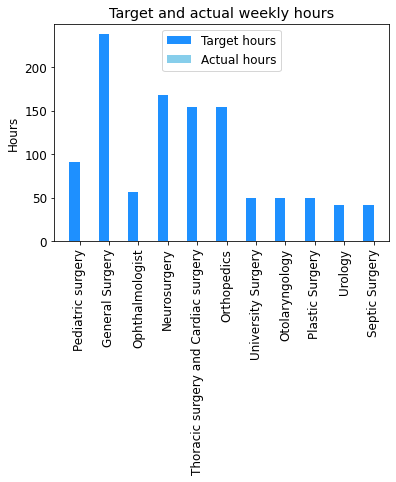

In [22]:

actual = results['Weekly total (hours)']
targets = weekly_targets

_ = fig, ax = plt.subplots()
_ = rects1 = ax.bar(np.arange(len(departments)) - 0.35/2, targets, width=0.35, label='Target hours',
                   color=colors['dodgerblue'])
_ = rects2 = ax.bar(np.arange(len(departments)) + 0.35/2, actual, width=0.35, label='Actual hours',
                   color=colors['skyblue'])
_ = ax.set_ylabel('Hours');
_ = ax.set_title('Target and actual weekly hours');
_ = ax.set_xticks(np.arange(len(departments)));
_ = ax.set_xticklabels(departments,rotation=90);
_ = ax.legend()

plt.show()

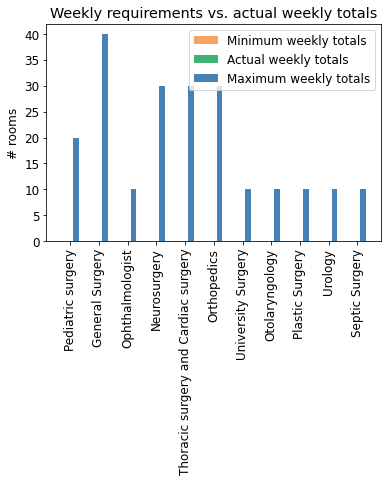

In [23]:
actual = results['Weekly total'] 

_ = fig, ax = plt.subplots()
_ = rects1 = ax.bar(np.arange(len(departments))-0.2, weekly_reqs[:,0], width=0.2, label='Minimum weekly totals',
                   color=colors['sandybrown'])
_ = rects2 = ax.bar(np.arange(len(departments)), results['Weekly total'] , width=0.2, label='Actual weekly totals',
                   color=colors['mediumseagreen'])
_ = rects3 = ax.bar(np.arange(len(departments))+0.2, weekly_reqs[:,1], width=0.2, label='Maximum weekly totals',
                   color=colors['steelblue'])
_ = ax.set_ylabel('# rooms');
_ = ax.set_title('Weekly requirements vs. actual weekly totals');
_ = ax.set_xticks(np.arange(len(departments)));
_ = ax.set_xticklabels(departments,rotation=90);
_ = ax.legend()

plt.show()




The next table shows the right-hand sides and the slacks in the constraints in the optimal solution (we do not consider the constraints which have been incorporated in the variables bounds). We can see that there are zero slacks in:
* The total number of operating rooms (constraints $C1$) on Tuesday, Wednesday and Tursday which are at the upper bound of 10 units. 
* In the constraint due to the maximum weekly requirements for operating rooms (constraints $C5$) in Oral Surgery, where the weekly total is at the lower bound of 2. 

It is interesting to investigate whether an increase in the total number of operating rooms on Tuesday, Wednesday or Tursday can lead to an improved value of the objective function.

In [24]:
constr_slacks = pd.DataFrame([[round(c.rhs,1), round(c.slack,1)] for c in m.constrs],
                       columns = ['RHS','Slack'])
constr_slacks

,RHS,Slack
0,14.0,0.0
1,14.0,0.0
2,14.0,0.0
3,14.0,0.0
4,15.0,0.0
5,-0.0,11.0
6,-0.0,0.0
7,-0.0,7.0
8,-0.0,0.0
9,-0.0,19.0


To check this, we make a small experiment, increasing the daily total in each day consecutively. We use the function *make_model()* created before, clearing the model each time, by calling the function *clear()*.

In [34]:
initial_daily = [14]*5
for j in range(5):
    new_daily = initial_daily.copy()
    new_daily[j] += 1
    print('\n--------------------\nDaily totals constraints: ',new_daily,'\n')

    m.clear() ; m = make_model(min_ors,max_ors,available_teams,weekly_targets,new_daily,weekly_reqs)
    SearchEmphasis = 1 ; LP_Method = 1 
    m.max_gap = 0.05
    m.preprocess = 1

    start_time = time.time()
    status = m.optimize()         
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {0:8.4f} found in {1:8.1f} seconds'.\
               format(round(m.objective_value,2),(time.time() - start_time)))
        results = pd.DataFrame([[m.var_by_name('x'+str(i)+'_'+str(j)).x for j in range(6,1)] for i in range(11,1)],
                       index = departments, columns = ['Mon','Tue','Wed','Thu','Fri'],dtype=int)
        results['Weekly total'] = results.apply(sum, axis=1)
        results['Weekly total (hours)'] = 7*results['Weekly total'] 
        results                      
        print('Daily totals:\n')
        print(results.apply(sum, axis=0)[:-2].values)
        
    else:
        print('Failed.')


--------------------
Daily totals constraints:  [15, 14, 14, 14, 14] 

optimal solution cost   6.4800 found in      0.0 seconds


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]

--------------------
Daily totals constraints:  [14, 15, 14, 14, 14] 

optimal solution cost   6.4800 found in      0.0 seconds


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]

--------------------
Daily totals constraints:  [14, 14, 15, 14, 14] 

optimal solution cost   6.4800 found in      0.0 seconds


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]

--------------------
Daily totals constraints:  [14, 14, 14, 15, 14] 

optimal solution cost   6.4800 found in      0.0 seconds


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]

--------------------
Daily totals constraints:  [14, 14, 14, 14, 15] 

optimal solution cost   6.4800 found in      0.0 seconds


,Mon,Tue,Wed,Thu,Fri,Weekly total,Weekly total (hours)
Pediatric surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
General Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ophthalmologist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neurosurgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Τhoracic surgery and Cardiac surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Orthopedics,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Otolaryngology,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Plastic Surgery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Urology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Daily totals:

[nan nan nan nan nan]


There is no improvement by these changes. We can see for example clearly that the rooms in General Surgery are re-allocated to accomodate the additional room but the total weekly allocation remains at 23. The interactions with the other constraints do not allow any improvement.  